In [3]:
from torchvision.datasets import Flowers102
from torchvision.models import resnet50
from math import cos
from math import pi
from math import ceil
from math import floor
from copy import deepcopy
from typing import List
from statistics import mean
from tqdm.auto import tqdm

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch

In [4]:
class Settings:
  runs = 4
  epochs = 10
  max_lr = 0.1
  min_lr = 0.0001
  size = 10

# Classes

In [5]:
class ModelCollection:
  def __init__(self, top_N: int = 5):
    self.top_N = top_N
    self.models     = []
    self.accuracies = []
    self.beta = None
    self.a    = None
    self.b    = None


  def record(self, model, accuracy) -> None:
    if len(self.models) < self.top_N:
      self.models.append(model)
      self.accuracies.append(accuracy)
      return

    for i, value in enumerate(self.accuracies):
      if value < accuracy:
        self.models[i]     = deepcopy(model)
        self.accuracies[i] = accuracy
        break


  def sort(self):
    self.models, self.accuracies = np.array(self.models), np.array(self.accuracies)
    sorted_index = np.argsort(self.accuracies)[::-1]

    self.models, self.accuracies = self.models[sorted_index], self.accuracies[sorted_index]


  def pruned(self) -> list:
    self.sort()
    self.calculate_bounds()
    self.calculate_beta()
    pruned_collection = []

    for i, value in enumerate(self.accuracies):
      tau = (1 - self.beta) * self.a + self.beta * self.b
      if value > tau:
        pruned_collection.append(self.models[i])

    return pruned_collection

  def calculate_bounds(self) -> None:
    self.a = max(self.accuracies)
    self.b = min(self.accuracies)


  def calculate_beta(self) -> bool:
    if self.beta is not None:
      return False

    self.beta = (self.a - mean(self.accuracies)) / (self.a - self.b)
    return True

In [6]:
class Ensemble:
  def __init__(self):
    self.models = []

  def infer(self, x):
    pass

# Loading The Dataset

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )
])

test_dataset = Flowers102(
    root="./data",
    download=True,
    split="train",
    transform=transform
)

train_dataset = Flowers102(
    root="./data",
    download=True,
    split="test",
    transform=transform
)

validation_dataset = Flowers102(
    root="./data",
    download=True,
    split="val",
    transform=transform
)

test_dataset = torch.utils.data.ConcatDataset([test_dataset, validation_dataset])

len(train_dataset), len(test_dataset)

100%|██████████| 344862509/344862509 [00:22<00:00, 15593018.51it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 669275.46it/s]


100%|██████████| 14989/14989 [00:00<00:00, 19670970.79it/s]


(6149, 2040)

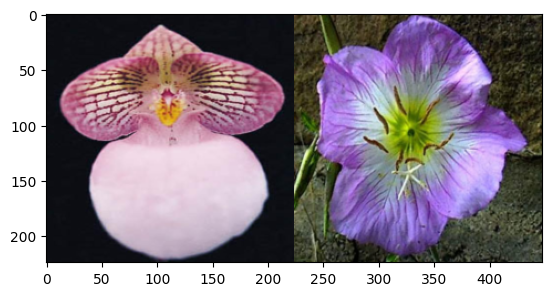

In [8]:
train_image = train_dataset[10][0]
train_image = train_image / 2 + 0.5
train_image = np.transpose(train_image, (1, 2, 0))

test_image = test_dataset[10][0]
test_image = test_image / 2 + 0.5
test_image = np.transpose(test_image, (1, 2, 0))

image = np.hstack((test_image, train_image))

plt.imshow(image)

# Functions

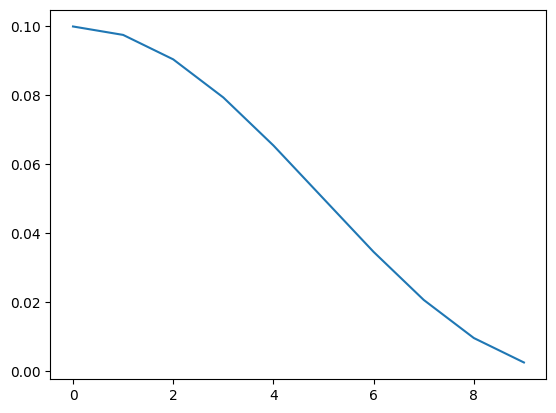

In [10]:
def divider(length: int = 50):
  print("_" * length, end="\n\n")


def learning_rate(t):
  difference = Settings.max_lr - Settings.min_lr
  return Settings.min_lr + 0.5 * (difference) * (1 + cos(t / Settings.epochs * pi))

learning_rate_visualization = np.arange(0, Settings.epochs)
l = np.vectorize(learning_rate)
learning_rate_visualization = l(learning_rate_visualization)
plt.plot(learning_rate_visualization)

# Loading The Model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
model = resnet50(pretrained=True)

model.fc = torch.nn.Linear(
    model.fc.in_features,
    102
)

for param in model.parameters():
  param.requires_grad = False

for param in model.fc.parameters():
  param.requires_grad = True

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

In [19]:
initial_correct = 0

model.eval()
with torch.inference_mode():
  for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    _, predictions = torch.max(model(images), 1)
    initial_correct += (predictions == labels).float().sum()

accuracy = initial_correct.item() / len(validation_dataset) * 100
accuracy = round(accuracy, 4)
print(f"Initial accuracy {accuracy}%")

Initial accuracy 0.9804%


# Training Phase

In [20]:
criterion        = torch.nn.CrossEntropyLoss()
collections      = [None] * Settings.runs
accuracy_history = [None] * Settings.runs

In [21]:
for run in range(Settings.runs):
  collections[run] = ModelCollection()
  optimizer = torch.optim.Adam(model.parameters(), lr=Settings.max_lr)
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[learning_rate])
  accuracy_history[run] = []

  # shuffle training dataset every run
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

  for epoch in range(Settings.epochs):
    model.train()
    for images, labels in train_dataloader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      predictions = model(images)
      loss = criterion(predictions, labels)
      loss.backward()
      optimizer.step()

    correct = 0
    model.eval()
    with torch.inference_mode():
      for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        _, predictions = torch.max(model(images), 1)
        correct += (predictions == labels).float().sum()

    accuracy = correct / len(test_dataset) * 100
    accuracy_history[run].append(accuracy.item())
    collections[run].record(model, accuracy.item())
    scheduler.step()

    print(f"epoch: {epoch + 1}, lr: {scheduler.get_last_lr()}, accuracy: {accuracy}, loss: {loss.item()}")

  divider()

epoch: 1, lr: [0.009755527298894293], accuracy: 24.411766052246094, loss: 19.953323364257812
epoch: 2, lr: [0.009046039886902862], accuracy: 48.72549057006836, loss: 5.789769172668457
epoch: 3, lr: [0.007940987335200904], accuracy: 65.3431396484375, loss: 2.1870274543762207
epoch: 4, lr: [0.006548539886902863], accuracy: 78.28431701660156, loss: 2.124394178390503
epoch: 5, lr: [0.005005000000000001], accuracy: 80.29412078857422, loss: 0.4584141671657562
epoch: 6, lr: [0.0034614601130971384], accuracy: 85.88236236572266, loss: 0.42513173818588257
epoch: 7, lr: [0.0020690126647990976], accuracy: 88.72549438476562, loss: 0.5511115789413452
epoch: 8, lr: [0.0009639601130971381], accuracy: 88.13726043701172, loss: 0.47384804487228394
epoch: 9, lr: [0.0002544727011057081], accuracy: 87.9411849975586, loss: 0.500625729560852
epoch: 10, lr: [1e-05], accuracy: 88.4313735961914, loss: 0.5066267251968384
__________________________________________________

epoch: 1, lr: [0.009755527298894293], acc

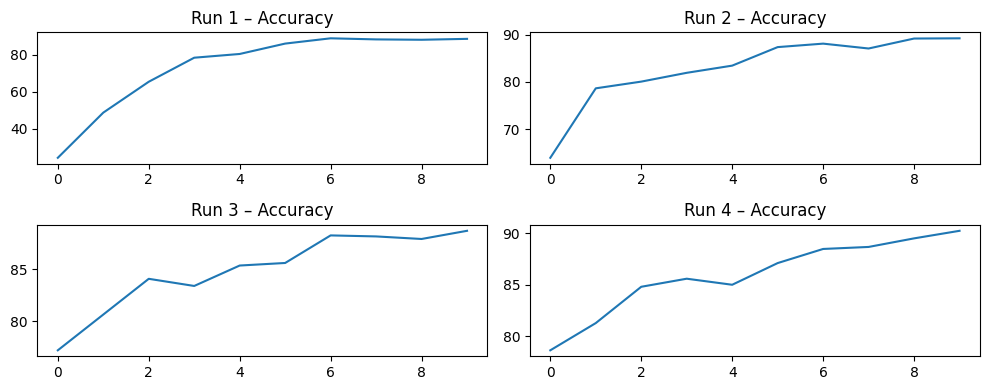

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(10, 4))

ax[0, 0].plot(accuracy_history[0])
ax[0, 0].set_title("Run 1 – Accuracy")
ax[0, 1].plot(accuracy_history[1])
ax[0, 1].set_title("Run 2 – Accuracy")
ax[1, 0].plot(accuracy_history[2])
ax[1, 0].set_title("Run 3 – Accuracy")
ax[1, 1].plot(accuracy_history[3])
ax[1, 1].set_title("Run 4 – Accuracy")

plt.tight_layout()
plt.show()

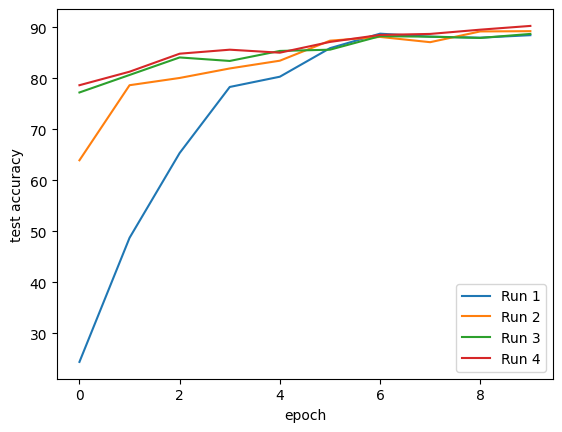

In [44]:
plt.plot(accuracy_history[0], label="Run 1")
plt.plot(accuracy_history[1], label="Run 2")
plt.plot(accuracy_history[2], label="Run 3")
plt.plot(accuracy_history[3], label="Run 4")
plt.xlabel("epoch")
plt.ylabel("test accuracy")
plt.legend(loc="lower right")
plt.show()

In [39]:
ensemble = []
collection_id = 0

while len(ensemble) < Settings.size and collection_id < len(collections):
  for pruned_model in collections[collection_id].pruned():
    ensemble.append(pruned_model)
    if len(ensemble) >= Settings.size:
      break
    collection_id += 1

In [40]:
len(ensemble)

5